# Week 6
# Solved by Hemant


In [37]:
# lets load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import LocalOutlierFactor



In [38]:
# lets load data set
train_df = pd.read_csv("/Users/hemant./Celebal/Week 6/titanic/train.csv")
test_df = pd.read_csv("/Users/hemant./Celebal/Week 6/titanic/test.csv")
gender_submission_df = pd.read_csv("/Users/hemant./Celebal/Week 6/titanic/gender_submission.csv")

In [39]:

# lets see the data set 
print("train datarame:")
print(train_df.head())

print("test dataframe:")
print(test_df.head())

print("\ngender submission dataframe:")
print(gender_submission_df.head())

# Display summary statistics
print("\ntrain DataFrame Summary Statistics:")
print(train_df.describe())

print("\ntest DataFrame summary Statistics:")
print(test_df.describe())

# Check for missing values
print("\nmissing values in train dataframe:")
print(train_df.isnull().sum())

print("\nmissing values in test dataframe:")
print(test_df.isnull().sum())

train datarame:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   N

In [40]:
# lets check the outliers
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * iqr
    up_limit = quartile3 + 1.5 * iqr
    return low_limit, up_limit

In [41]:
# lets remove outliers 
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [42]:
#lets replace some values 
# handle values 
def preprocess_data(df):
    df['Age'].fillna(df['Age'].median(), inplace=True)
    
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0
    
    df['AgeBin'] = pd.cut(df['Age'].astype(int), 5)
    
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['FareBin'] = pd.qcut(df['Fare'], 4)
    

    replace_with_thresholds(df, 'Age')
    replace_with_thresholds(df, 'Fare')
    
    return df

In [43]:
# lets preprocess 
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)


/Users/hemant./anaconda3/lib/python3.11/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/hemant./anaconda3/lib/python3.11/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [44]:
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Title  FamilySize  IsAlone  \
0      0         A/5 21171   7.2500   NaN        S    Mr           2        0   
1      0          PC 17599  65.6344   C85        C   Mrs           2        0   
2      0  STON/O2. 3101282   7.9250   NaN        S  Miss           1        1

In [45]:
print(test_df.head())


   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

      Age  SibSp  Parch   Ticket     Fare Cabin Embarked Title  FamilySize  \
0  34.500      0      0   330911   7.8292   NaN        Q    Mr           1   
1  47.000      1      0   363272   7.0000   NaN        S   Mrs           2   
2  54.875      0      0   240276   9.6875   NaN        Q    Mr           1   
3  27.000      0      0   315154   8.6625   NaN        S    Mr           1   
4  22.000      1      1  3101298  12.2875   NaN        S   Mrs           3   

   IsAlone        AgeBin          FareBin  
0     

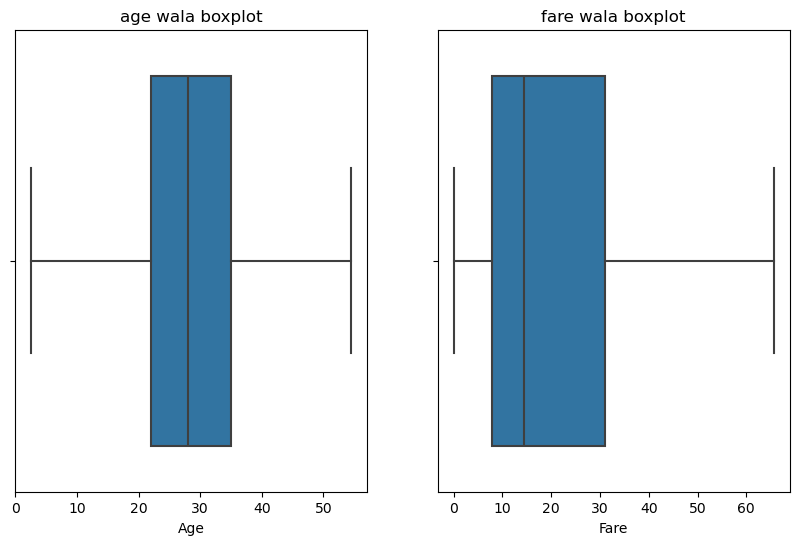

In [46]:
# lets visualise the things 
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=train_df["Age"])
plt.title('age wala boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(x=train_df["Fare"])
plt.title('fare wala boxplot')

plt.show()

# Solved By Hemant